In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from interstellar import Tracks, DenseNetworkGrid, set_seed

In [3]:
name = 'grid_11'
tracks = 'tracks_04'
save_path = f'/home/ADF/ajl573/Data/interstellar_data/{name}'
load_path = f'/home/ADF/ajl573/Data/interstellar_data/{tracks}'

In [72]:
train = pd.read_csv(f'{load_path}/{tracks}_train.csv')
val = pd.read_csv(f'{load_path}/{tracks}_val.csv')

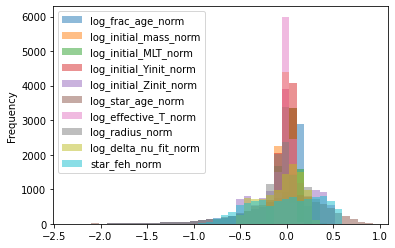

In [5]:
train.sample(n=10000).plot(kind='hist', bins=40, alpha=0.5)

In [6]:
x_cols = ['log_frac_age_norm', 'log_initial_mass_norm', 'log_initial_MLT_norm',
          'log_initial_Yinit_norm', 'log_initial_Zinit_norm']
y_cols = ['log_star_age_norm', 'log_effective_T_norm', 'log_radius_norm',
          'log_delta_nu_fit_norm', 'star_feh_norm']

In [7]:
print(f'Length of training data = {len(train)}')
print(f'Length of validation data = {len(val)}')

Length of training data = 6020261
Length of validation data = 1505065


In [8]:
n_batches = np.arange(500, 2000)  # Select a range where number of batches is reasonable
r = (len(train)) % n_batches 

# Print whole multiples of training size
print(f'choose number of batches from:\n{n_batches[r==0]}')

choose number of batches from:
[]


No matches, so we choose remainders less than 10

In [9]:
print(f'choose number of batches from:\n{n_batches[r<20]}')

choose number of batches from:
[ 523  528  541  575  612  626  665  690  698  750  823  844  849  856
  918 1013 1019 1045 1047 1056 1082 1093 1150 1279 1377 1391 1463 1477
 1569 1725 1745 1836 1889 1981]


We can afford to drop 20 points randomly and this gives us more choice for the number of batches. Since we've added more points we should think about keeping the number of batches fairly high. Let's choose 612

In [16]:
n_drop = r[n_batches==612]
n_drop

array([17])

In [18]:
seed = 101
train = train.sample(n=len(train)-n_drop, random_state=seed)

Double-check

In [19]:
len(train) % 612

0

In [24]:
depth = [5, 8]
width = [128, 256]
activation = ['relu', 'elu']
batch_size = len(train)//612
regularization_l2 = [0.0, 1e-10, 1e-5]
optimizer = 'nadam'
loss = 'mse'
metrics = ['mae']

In [25]:
grid = DenseNetworkGrid(path=save_path, name=name, depth=depth, width=width,
                        activation=activation, batch_size=batch_size,
                        regularization_l2=regularization_l2)

grid.data

,depth,width,activation,batch_size,regularization_l2
name,,,,,
grid_11_0,5,128,relu,9837,0.000000e+00
grid_11_1,5,128,relu,9837,1.000000e-10
grid_11_2,5,128,relu,9837,1.000000e-05
grid_11_3,5,128,elu,9837,0.000000e+00
grid_11_4,5,128,elu,9837,1.000000e-10
grid_11_5,5,128,elu,9837,1.000000e-05
grid_11_6,8,128,relu,9837,0.000000e+00
grid_11_7,8,128,relu,9837,1.000000e-10
grid_11_8,8,128,relu,9837,1.000000e-05


In [26]:
grid.make_networks()

In [27]:
grid.build_all(len(x_cols), len(y_cols))

In [30]:
grid.compile_all(optimizer=optimizer, loss=loss, metrics=metrics)

In [31]:
grid.train_all(train, x_cols, y_cols, epochs=50, validation_data=val, validation_split=None,
               callbacks=['tensorboard'], network_kw={'nth_row': 5})

Add a function which plots history for all networks.

In [38]:
np.convolve(network.history.val_loss, np.ones((5,))/5, mode='valid')

array([0.0069207 , 0.00453242, 0.00332112, 0.00258636, 0.00524898,
       0.00564422, 0.00596715, 0.00619997, 0.0067952 , 0.00404722,
       0.00377136, 0.00354937, 0.00341806, 0.00295179, 0.00269802,
       0.00239594, 0.0022269 , 0.00206019, 0.00194053, 0.00188733,
       0.00177682, 0.00171454, 0.00155944, 0.00152208, 0.00142853,
       0.00139088, 0.00133695, 0.00135215, 0.00128747, 0.00125559,
       0.00122238, 0.00119975, 0.00114969, 0.00114037, 0.0011292 ,
       0.00112242, 0.00114089, 0.0012366 , 0.00125109, 0.00124709,
       0.00123468, 0.00120739, 0.00108967, 0.00107012, 0.00105085,
       0.00105463])

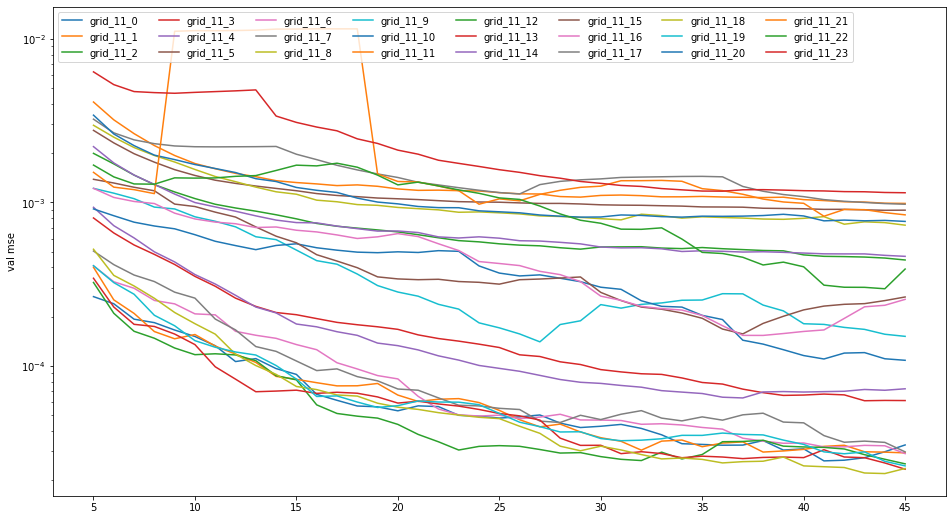

In [56]:
fig, ax = plt.subplots(figsize=(16, 9))
filter_width = 10  # filter width in epochs

for network in grid.networks:
#     network.history.plot(ax=ax, x='epochs', y=['val_loss'], logy=True, alpha=0.5,
#                          label=[f'{network.name} val loss'])
    df = network.history
    y = np.convolve(network.history.val_loss, np.ones((filter_width,))/filter_width, mode='valid')
    ax.plot(df.iloc[n//2:-n//2+1].epochs, y, label=f'{network.name}')
ax.set_ylabel(f'val {loss}')
ax.set_yscale('log')

ax.legend(loc='upper left', ncol=8)

In [57]:
grid.evaluate_all(val.sample(n=5000))

,loss,mae
name,,
grid_11_0,0.000045,0.004117
grid_11_1,0.000012,0.002278
grid_11_2,0.000445,0.006880
grid_11_3,0.000054,0.004166
grid_11_4,0.000070,0.005474
grid_11_5,0.000904,0.011948
grid_11_6,0.000028,0.003203
grid_11_7,0.000019,0.002839
grid_11_8,0.000647,0.009045


In [58]:
import seaborn as sns

In [59]:
# val = val.sample(n=10000)

In [74]:
df_dict = {}
for i, network in enumerate(grid.networks):
#     network = grid.networks[i]
    df_dict[network.name] = np.abs(network.model.predict(val[x_cols], batch_size=15000) - val[y_cols].reset_index(drop=True))

In [75]:
df_err = pd.concat(df_dict).reset_index(level=0).rename(columns={'level_0': 'name'})
df_err.head()

,name,log_star_age_norm,log_effective_T_norm,log_radius_norm,log_delta_nu_fit_norm,star_feh_norm
0,grid_11_0,0.005740,0.000569,0.002543,0.003763,0.009372
1,grid_11_0,0.001853,0.002076,0.008251,0.011526,0.005169
2,grid_11_0,0.003702,0.000898,0.000289,0.000078,0.000592
3,grid_11_0,0.000006,0.000581,0.002403,0.001638,0.005374
4,grid_11_0,0.004288,0.007342,0.008404,0.011584,0.002664


In [76]:
df_mae = pd.concat(df_dict).mean(axis=1).reset_index(level=0).rename(columns={'level_0': 'name', 0: 'mae'})
df_mae.head()

,name,mae
0,grid_11_0,0.004398
1,grid_11_0,0.005775
2,grid_11_0,0.001112
3,grid_11_0,0.002000
4,grid_11_0,0.006856


In [77]:
df_mae['log_mae'] = np.log10(df_mae['mae'])

In [78]:
order = df_mae.set_index('name').median(level=0).sort_values('log_mae', ascending=False).index

In [79]:
df_err.head()

,name,log_star_age_norm,log_effective_T_norm,log_radius_norm,log_delta_nu_fit_norm,star_feh_norm
0,grid_11_0,0.005740,0.000569,0.002543,0.003763,0.009372
1,grid_11_0,0.001853,0.002076,0.008251,0.011526,0.005169
2,grid_11_0,0.003702,0.000898,0.000289,0.000078,0.000592
3,grid_11_0,0.000006,0.000581,0.002403,0.001638,0.005374
4,grid_11_0,0.004288,0.007342,0.008404,0.011584,0.002664


In [82]:
df_err = df_err.sample(20000)

In [83]:
df_err_col = df_err.set_index('name').stack().reset_index().rename(columns={'level_1': 'output',
                                                                0: 'abs_err'})

df_err_col['log_abs_err'] = np.log10(df_err_col['abs_err'])

<IPython.core.display.Javascript object>


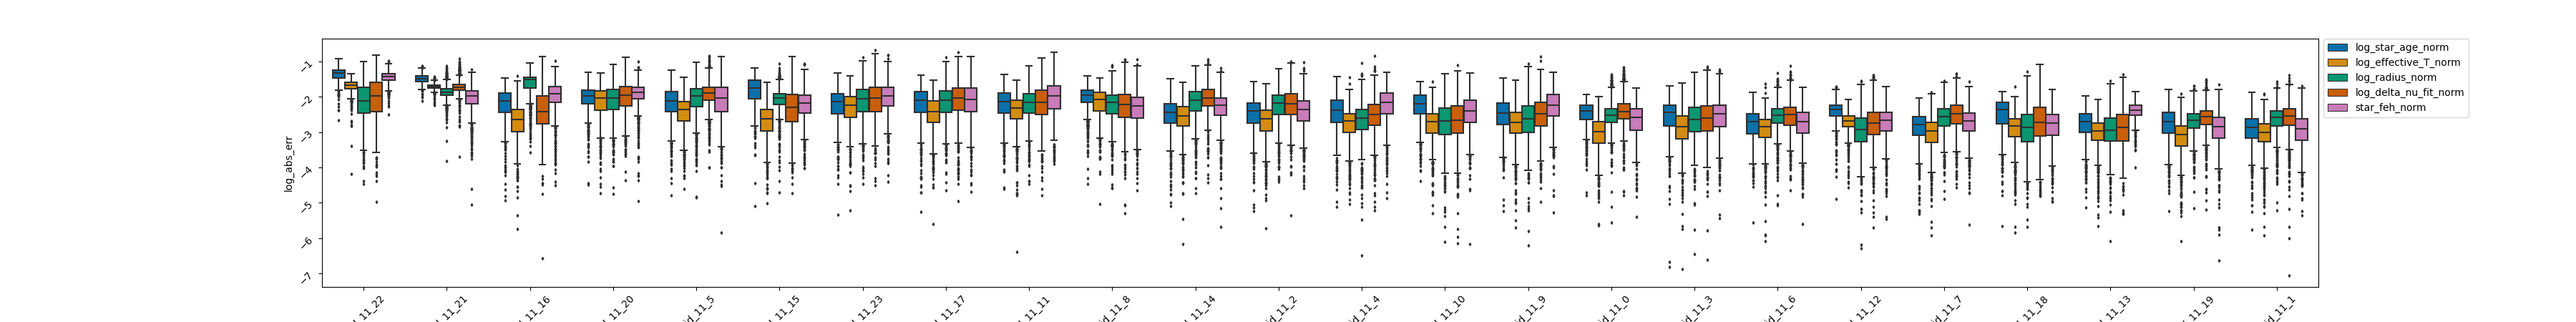

In [84]:
%matplotlib notebook

w = 1.5 * len(grid.data)
fig, ax = plt.subplots(figsize=(w, 4.5))
width = 0.15 * len(y_cols)
sns.boxplot(data=df_err_col, x='name', y='log_abs_err', hue='output',
            width=width, fliersize=2, color='C0', palette='colorblind',
            order=order, ax=ax, saturation=0.9)
# ax.set_yscale('log')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
ax.legend(bbox_to_anchor=(1.0, 1.02))

In [86]:
scores = grid.score_all(val.sample(20000), metric='absolute_error')

In [87]:
scores.xs('std', level=1)

,log_star_age_norm,log_effective_T_norm,log_radius_norm,log_delta_nu_fit_norm,star_feh_norm
grid_11_0,0.002403,0.001523,0.005613,0.008547,0.002695
grid_11_1,0.001375,0.001121,0.002567,0.003849,0.001785
grid_11_2,0.004049,0.003306,0.008565,0.012758,0.007459
grid_11_3,0.003028,0.002988,0.006391,0.009582,0.005109
grid_11_4,0.005595,0.002414,0.004875,0.007404,0.007887
grid_11_5,0.007969,0.004692,0.011355,0.016703,0.017533
grid_11_6,0.001800,0.001340,0.004787,0.007416,0.002214
grid_11_7,0.001582,0.001218,0.003411,0.005079,0.002134
grid_11_8,0.006263,0.006534,0.007824,0.012108,0.009247
grid_11_9,0.004149,0.002847,0.005496,0.008025,0.007862
